In [ ]:
import numpy as np
import pandas as pd
import cv2 as cv
from torch.utils.data import Dataset, DataLoader
from glob import glob 
from matplotlib import pyplot as plt
from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%ls

drive/  sample_data/


In [ ]:
%cd /content/drive/MyDrive/ТМСС

/content/drive/MyDrive/ТМСС


# ***Постановка задач***
выполнить классификацию indoor/outdoor на выделенном дата сете
на основе статьи https://vismod.media.mit.edu/pub/tech-reports/TR-445.pdf

работа выполнена на коллабе, следовательно в связи с ограниченностью памяти в гугл драйве, была использована симпл версии датасета

In [ ]:
train_path = 'SimpleCube++.zip (Unzipped Files)/SimpleCube++/auxiliary/train_properties.csv'
test_path = 'SimpleCube++.zip (Unzipped Files)/SimpleCube++/auxiliary/test_properties.csv'
img_path = '/content/drive/MyDrive/ТМСС/SimpleCube++.zip (Unzipped Files)/SimpleCube++/auxiliary/JPG'
sub_img_x = 3
sub_img_y = 3
color_bin = 8

In [ ]:
data_summ = pd.read_csv(train_path)

In [ ]:
data_summ.head()

,image,ds_version,daytime,place,illumination,is_sharp,shadows
0,00_0002,0.0,day,outdoor,natural,True,no
1,00_0004,0.0,day,outdoor,natural,True,no
2,00_0007,0.0,day,outdoor,natural,True,no
3,00_0013,0.0,day,outdoor,natural,True,no
4,00_0015,1.0,unknown,indoor,unknown,True,yes


In [ ]:
train_data = data_summ[['image', 'place']]
train_data.head()

,image,place
0,00_0002,outdoor
1,00_0004,outdoor
2,00_0007,outdoor
3,00_0013,outdoor
4,00_0015,indoor


In [ ]:
test_data = pd.read_csv(test_path)[['image', 'place']]
test_data.head()

,image,place
0,00_0010,indoor
1,00_0011,outdoor
2,00_0019,outdoor
3,00_0046,outdoor
4,00_0057,outdoor


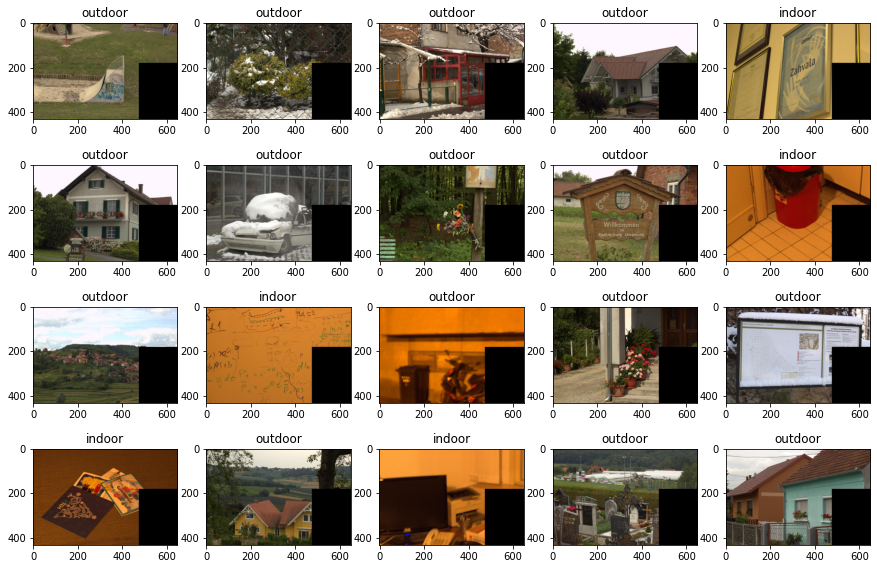

In [ ]:
fig, axs = plt.subplots(4, 5, figsize=(15, 10))
idx = 0
for i in range(4):
  for j in range(5):
    img_sample, label = train_data.values[idx]
    img = plt.imread(f'{img_path}/train_{img_sample}.jpg')
    axs[i,j].set_title(label)
    axs[i,j].imshow(img)
    idx += 1

## **проверка сбалансированнотси классов**

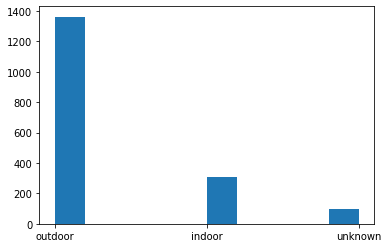

In [ ]:
plt.hist(train_data['place'])
plt.show()

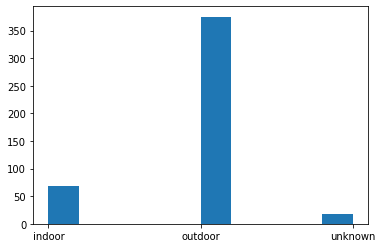

In [ ]:
plt.hist(test_data['place'])
plt.show()

разница в разметке в процентном соотношении

In [ ]:
train_data[train_data['place'] == 'indoor'].shape[0] / train_data[train_data['place'] == 'outdoor'].shape[0]

0.22743947175348497

In [ ]:
test_data[test_data['place'] == 'indoor'].shape[0] / test_data[test_data['place'] == 'outdoor'].shape[0]

0.184

просмотр неорпделённых изображении

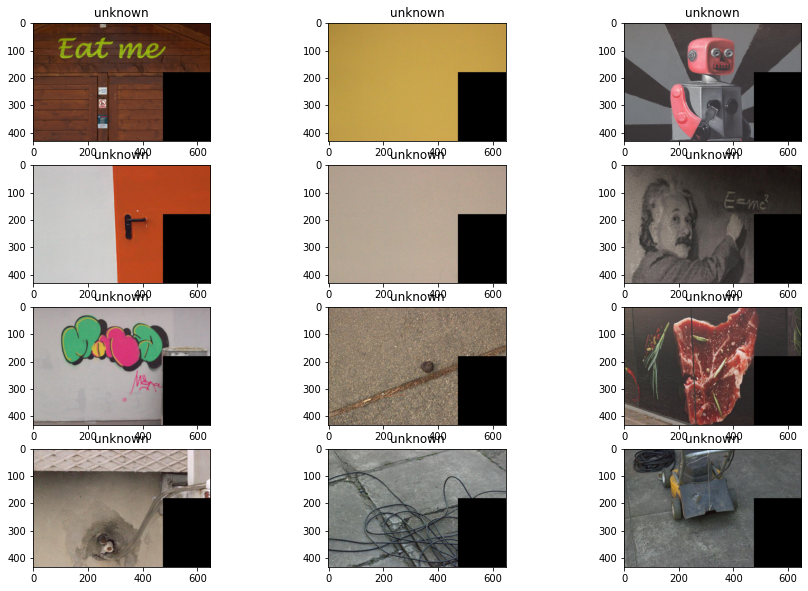

In [ ]:
fig, axs = plt.subplots(4, 3, figsize=(15, 10))
idx = 0
for i in range(4):
  for j in range(3):
    img_sample, label = train_data[train_data['place'] == 'unknown'].values[idx]
    img = plt.imread(f'{img_path}/train_{img_sample}.jpg')
    axs[i,j].set_title(label)
    axs[i,j].imshow(img)
    idx += 1

было принято решение выбросить такие данные с обучающей и тестовой выборки в связи относительно небольшого количества, так же данные изображения сильно отличаются от основного множества, что может негативно повлиять на качество обучения модели

In [ ]:
train_data.drop(index=train_data[train_data['place'] == 'unknown'].index, inplace=True)
test_data.drop(index=test_data[test_data['place'] == 'unknown'].index, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


для решения проблемы сильного дисбаланса между классами, была воспользована аугментация данных для меньшего по размеру класса, ниже приведены примеры аугментации

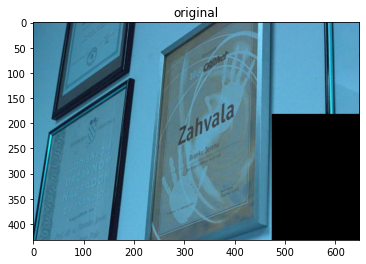

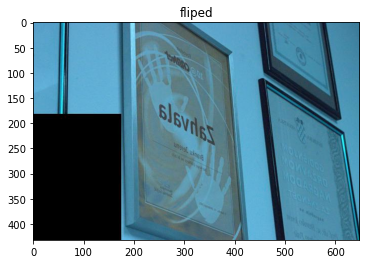

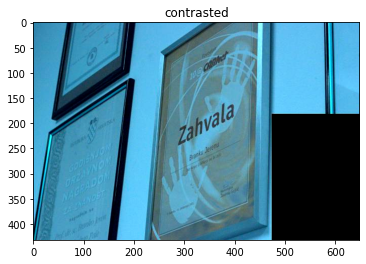

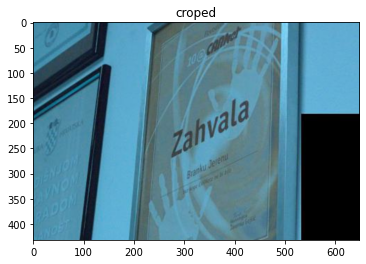

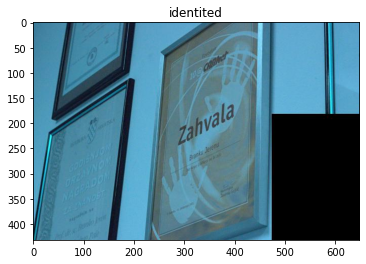

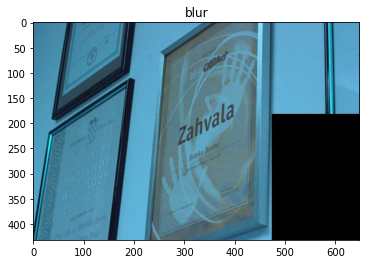

In [ ]:
for img_name, label in train_data[train_data['place'] == 'indoor'].values:
  img = cv.imread(f'{img_path}/train_{img_name}.jpg')
  plt.title('original')
  plt.imshow(img)
  plt.show()

  fliped_img = cv.flip(img, 270)
  plt.title('fliped')
  plt.imshow(fliped_img)
  plt.show()

  brightness = 10
  contrast = np.random.randint(40, 100)
  dummy = np.int16(img)
  dummy = dummy * (contrast/127+1) - contrast + brightness
  dummy = np.clip(dummy, 0, 255)
  ctr_img = np.uint8(dummy)
  plt.title('contrasted')
  plt.imshow(ctr_img)
  plt.show()

  left_corner_x = int(np.random.randint(7, 20, 1) * img.shape[0]/100)
  left_corner_y = int(np.random.randint(7, 20, 1) * img.shape[1]/100)
  right_corner_x = int(img.shape[0] - np.random.randint(7, 20, 1) * img.shape[0]/100)
  right_corner_y = int(img.shape[1] - np.random.randint(7, 20, 1) * img.shape[1]/100)
  croped_img = img[left_corner_x:right_corner_x, left_corner_y: right_corner_y, :]
  croped_img = cv.resize(croped_img, (img.shape[1],img.shape[0]))
  plt.title('croped')
  plt.imshow(croped_img)
  plt.show()


  kernel = np.array([[0,0,0], 
                     [0,1,0],
                     [0,0,0]])
  Identity = cv.filter2D(src=img, ddepth=-1, kernel=kernel)
  plt.title('identited')
  plt.imshow(Identity)
  plt.show()




  kernel2 = np.ones((5, 5), np.float32) / 25
  blur = cv.filter2D(src=img, ddepth=-1, kernel=kernel2)
  plt.title('blur')
  plt.imshow(Identity)
  plt.show()

  break

определены функции для аугментации 

In [ ]:
def fliped_image(img):
  deg = np.random.choice([90, 0], 1)[0]
  return cv.flip(img, deg)

def contrasted_image(img):
  brightness = 10
  contrast = np.random.randint(40, 100)
  dummy = np.int16(img)
  dummy = dummy * (contrast/127+1) - contrast + brightness
  dummy = np.clip(dummy, 0, 255)
  ctr_img = np.uint8(dummy)
  return ctr_img


def croped_image(img):
  left_corner_x = int(np.random.randint(7, 20, 1) * img.shape[0]/100)
  left_corner_y = int(np.random.randint(7, 20, 1) * img.shape[1]/100)
  right_corner_x = int(img.shape[0] - np.random.randint(7, 20, 1) * img.shape[0]/100)
  right_corner_y = int(img.shape[1] - np.random.randint(7, 20, 1) * img.shape[1]/100)
  croped_img = img[left_corner_x:right_corner_x, left_corner_y: right_corner_y, :]
  return cv.resize(croped_img, (img.shape[1], img.shape[0]))


def identitied_image(img):
  kernel = np.array([[0,0,0], 
                     [0,1,0],
                     [0,0,0]])
  Identity = cv.filter2D(src=img, ddepth=-1, kernel=kernel)
  return Identity


def blur_image(img):
  kernel2 = np.ones((5, 5), np.float32) / 25
  blur = cv.filter2D(src=img, ddepth=-1, kernel=kernel2)
  return blur

In [ ]:
augs = [fliped_image, croped_image, contrasted_image, identitied_image, blur_image]

## Выбор методик

Основная идея статьи состоит в том чтобы выделить цветовые и текстурные фичи не для всего изображения, а брать с "подизображении". Выполнить предсказание для каждого "подизображения" и на основе них выполнить предсказание осного 

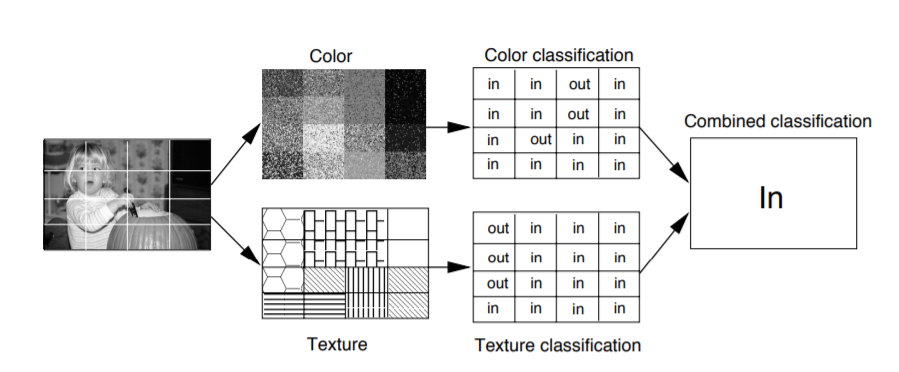

взяв эту идею каждое изображение будет разделено на 10 мелких изображении как показано ниже на картинке 

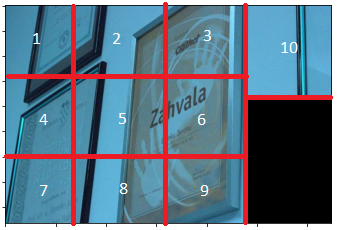

В связи с особенности датасета, каждое изображение имеет вырезанную часть с кубом для определения контрасноти изображения. Селдовательно эта часть не будет браться для обучения модели

Ниже определяется координаты чёрного участка. Эти координаты идентичны для каждого изображения

In [ ]:
sample = plt.imread(f'{img_path}/train_{train_data.values[0][0]}.jpg')
window_x = int(sample.shape[0]/10)
window_y = int(sample.shape[1]/10)
step_x = 1
step_y = 1
croped_x = []
croped_y = []
for i in range(0, sample.shape[0], step_x):
  for j in range(0, sample.shape[1], step_y):
    window = sample[i:i + window_x, j:j + window_y, :]
    if window.sum() == 0:
     croped_x.append(i)
     croped_y.append(j)
black_x = min(croped_x)
black_y = min(croped_y)
print(black_x)
print(black_y)

192
479


часть с разделением изображения описана в виде декоратора 

In [ ]:
def image_crop(func):
  def inner(*args, **kwargs):
    features = []
    for img_name,label in tqdm(kwargs['data'].values):
      true_img = plt.imread(f'{img_path}/{kwargs["phase"]}_{img_name}.jpg')
      img = true_img[:, :-black_y, :].copy()
      step_x = int(img.shape[0]/sub_img_x) + 1
      step_y = int(img.shape[1]/sub_img_y) + 1
      for i in range(0, img.shape[0], step_x):
        for j in  range(0, img.shape[1], step_y):
          sub_img = img[i: i + step_x, j : j +step_y, :]
          if label == 'indoor':
             # условие для класса с меньшей мощности 
            for aug_number in range(5):
              # аугментация проводится 5 раз из-за 
              # соответствующей разницы в объёме выборки каждого класса
              aug1, aug2 = np.random.choice(augs, 2)
              aug_img = aug2(aug1(sub_img))
              func(features, aug_img, f'{img_name}_aug{aug_number}', label)
          func(features, sub_img, img_name, label)
      # подизображение над чёрным участком обрабатывается отдельно
      over_black_img = true_img[:black_x, black_y:, :]
      if label == 'indoor':
            for aug_number in range(5):
              aug1, aug2 = np.random.choice(augs, 2)
              aug_img = aug2(aug1(over_black_img))
              func(features, aug_img, f'{img_name}_aug{aug_number}', label)
      func(features, over_black_img, img_name, label)
    return np.array(features)
  return inner

## Извлечение цветовых характеристик

цветовые характеристики извлекаются в два этапа


1) на основе гитограммы пикселей для каждого канала,


2) переход на цветовое пространство Otha


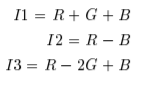

данные переход позволяет получить примерно декоррелированные цвета

In [ ]:
@image_crop
def get_color_features(hist_features, sub_img, img_name, label):
  features = []
  hists = np.array([None, None, None])
  Ohta = np.array([None, None, None])
  for z in range(sub_img.shape[2]):
    hists[z] = np.histogram(sub_img[:,:, z], list(range(0, 255, int(255/color_bin))))[0]
  # перезод на цветовое пространство Ohta
  Ohta[0] = hists[0] + hists[1] + hists[2]
  Ohta[1] = hists[0] - hists[2]
  Ohta[2] = hists[0] - 2*hists[1] + hists[2]
  features = np.concatenate((features, *Ohta))
  features = np.concatenate((features, [img_name]))
  features = np.concatenate((features, [label]))
  hist_features.append(features)
  return hist_features


вывод цветовых характеристик для всего датасета (тренировочного и тестового) сразу для дальнейшего удобства в процессе обучения

In [ ]:
train_color_hists = get_color_features(data = train_data, phase = 'train')
train_color_hists.shape

100%|██████████| 1673/1673 [09:13<00:00,  3.02it/s]


(32230, 26)

In [ ]:
test_color_hists = get_color_features(data = test_data, phase = 'test')
test_color_hists.shape

100%|██████████| 444/444 [03:12<00:00,  2.31it/s]


(7890, 26)

In [ ]:
color_decoder = {
    0: 'red',
    1: 'green',
    2: 'blue'
}
columns = [f'{color_decoder[i]}{j}' for i in color_decoder for j in range(color_bin)]
columns.append('image')
columns.append('labels')

сохранение цветовых характеристик в виде датасета

In [ ]:
train_color_hists = pd.DataFrame(train_color_hists, columns = columns)
train_color_hists.to_csv('./train_color_feature.csv', index_label=False)
train_color_hists.head()

,red0,red1,red2,red3,red4,red5,red6,red7,green0,green1,green2,green3,green4,green5,green6,green7,blue0,blue1,blue2,blue3,blue4,blue5,blue6,blue7,image,labels
0,264.0,4284.0,5111.0,9261.0,3344.0,2285.0,246.0,0.0,-122.0,-4016.0,-971.0,2678.0,598.0,1587.0,246.0,0.0,78.0,3930.0,-955.0,-2190.0,-1300.0,191.0,246.0,0.0,00_0002,outdoor
1,858.0,5290.0,7210.0,7488.0,2467.0,1307.0,175.0,0.0,-179.0,-4481.0,997.0,1988.0,592.0,910.0,173.0,0.0,93.0,3805.0,-2177.0,-1230.0,-788.0,128.0,169.0,0.0,00_0002,outdoor
2,1037.0,4454.0,5992.0,7270.0,3529.0,1302.0,309.0,32.0,-297.0,-2337.0,-640.0,638.0,1671.0,710.0,223.0,32.0,155.0,2615.0,-806.0,-2456.0,343.0,66.0,51.0,32.0,00_0002,outdoor
3,233.0,4952.0,9066.0,6578.0,2795.0,913.0,247.0,8.0,-233.0,-4593.0,1497.0,1495.0,1018.0,591.0,222.0,1.0,233.0,4247.0,-2937.0,-1219.0,-532.0,19.0,190.0,-1.0,00_0002,outdoor
4,138.0,4660.0,8366.0,7514.0,2940.0,1169.0,8.0,0.0,-138.0,-4470.0,799.0,1594.0,1146.0,1061.0,8.0,0.0,138.0,4288.0,-2689.0,-1144.0,-1446.0,845.0,8.0,0.0,00_0002,outdoor


In [ ]:
test_color_hists = pd.DataFrame(test_color_hists, columns = columns)
test_color_hists.to_csv('./test_color_feature.csv', index_label=False)
test_color_hists = pd.read_csv('./test_color_feature.csv')
test_color_hists.head()

,red0,red1,red2,red3,red4,red5,red6,red7,green0,green1,green2,green3,green4,green5,green6,green7,blue0,blue1,blue2,blue3,blue4,blue5,blue6,blue7,image,labels
0,8265.0,0.0,0.0,0.0,0.0,8265.0,0.0,0.0,-8265.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8265.0,0.0,0.0,0.0,0.0,-16530.0,0.0,0.0,00_0010_aug0,indoor
1,0.0,8265.0,0.0,0.0,8265.0,0.0,0.0,8265.0,0.0,-8265.0,0.0,0.0,0.0,0.0,0.0,8265.0,0.0,8265.0,0.0,0.0,-16530.0,0.0,0.0,8265.0,00_0010_aug1,indoor
2,8265.0,0.0,0.0,0.0,8265.0,0.0,0.0,0.0,-8265.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8265.0,0.0,0.0,0.0,-16530.0,0.0,0.0,0.0,00_0010_aug2,indoor
3,8265.0,0.0,0.0,0.0,0.0,8265.0,0.0,0.0,-8265.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8265.0,0.0,0.0,0.0,0.0,-16530.0,0.0,0.0,00_0010_aug3,indoor
4,0.0,8265.0,0.0,0.0,8265.0,0.0,0.0,8265.0,0.0,-8265.0,0.0,0.0,0.0,0.0,0.0,8265.0,0.0,8265.0,0.0,0.0,-16530.0,0.0,0.0,8265.0,00_0010_aug4,indoor


## обучение моделей на основе цветовых характеристик

в стаье активно используется модель KNN, так что был сделан соответствующий выбор 

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import DistanceMetric
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder

In [ ]:
train_X_color = train_color_hists[train_color_hists.columns[:-2]].values
train_y_color = train_color_hists[train_color_hists.columns[-1]].values
test_X_color = test_color_hists[test_color_hists.columns[:-2]].values
test_y_color = test_color_hists[test_color_hists.columns[-1]].values

в статье рекомендуется использовать данную метрику, так что был выполнен аналогичный экперимент 

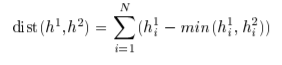

In [ ]:
def color_metric(h1, h2):
  return np.sum(h1 - np.minimum(h1, h2))

проверка сбалансированности классов

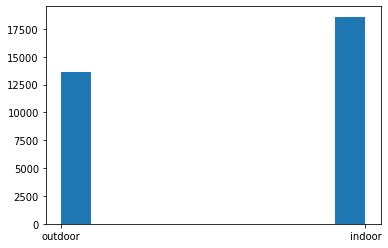

In [ ]:
plt.hist(train_y_color)
plt.show()

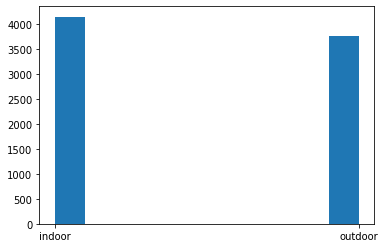

In [ ]:
plt.hist(test_y_color)
plt.show()

на основе метрики с статьи

In [ ]:
knn = KNeighborsClassifier(13, metric=color_metric)
knn.fit(train_X_color, train_y_color)
predicts = knn.predict(test_X_color)

In [ ]:
accuracy_score(test_y_color , predicts)

0.8608365019011407

In [ ]:
encoder = LabelEncoder().fit(test_y_color)
true_y = encoder.transform(test_y_color)
predicted_y = encoder.transform( predicts)

In [ ]:
f1_score(true_y, predicted_y)

0.8654741484930165

euc metric

In [ ]:
knnEUC_color = KNeighborsClassifier(13)
knnEUC_color.fit(train_X_color, train_y_color)
test_predicts_color = knnEUC_color.predict(test_X_color)
train_predicts_color = knnEUC_color.predict(train_X_color)

In [ ]:
accuracy_score(test_y_color , test_predicts_color)

0.8893306825712393

In [ ]:
encoder = LabelEncoder().fit(test_y_color)
true_y = encoder.transform(test_y_color)
predicted_y = encoder.transform(test_predicts_color)

In [ ]:
f1_score(true_y, predicted_y)

0.8863694923988663

как это не было странно обычное евклидово растояние показало лучший результат

# Извлечение текстурных данных

для извлечения текстурных данных используется авторагресиионная модель MSAR (multiresolution simultaneous autoregressive)

за основу берётся SAR модель, которая предсказывает значение пикселя, по её соседям

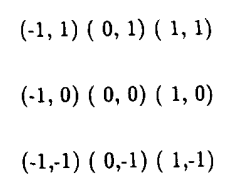

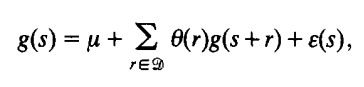

где s = (0, 0)

соответственно MSAR модель берёт не только соседние пиксели, но и те, которые находятся дальше 

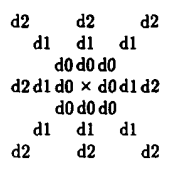

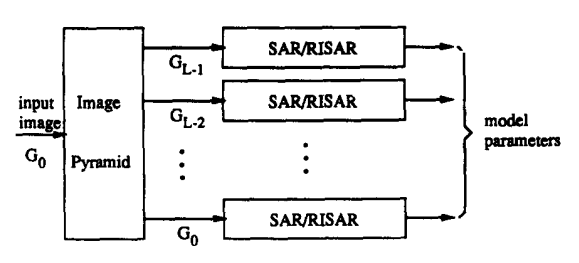

в качестве характеритик буду использоватся веса моделей MSAR для каждого подизображения

In [ ]:
@image_crop
def get_texture_features(texture_features, sub_img, img_name, class_value, neighbors = 3, stride = 3):
  gray_sub_img = cv.cvtColor(sub_img, cv.COLOR_BGR2GRAY)
  pixels = []
  labels = []
  for i in range(neighbors, gray_sub_img.shape[0] - neighbors, stride):
    for j in range(neighbors, gray_sub_img.shape[1] - neighbors, stride):
      vector=[]
      value = None
      for neighbor in range(1, neighbors + 1):
        # выбор соседних пикселей
        value = gray_sub_img[i, j]
        window = gray_sub_img[i - neighbor: i + neighbor+1, j -  neighbor :  j + neighbor+1]
        end_x, end_y = window.shape
        end_x -= 1
        end_y -= 1
        [vector.append(pix) for pix in  [window[0, 0], window[0, neighbor],window[0, end_y], window[neighbor, end_y], window[end_x, end_y],  window[end_x, neighbor], window[end_x, 0],window[ neighbor, 0]]]
      labels.append(value)
      pixels.append(vector)
  labels = np.array(labels)
  pixels = np.array(pixels)
  noise = np.random.normal(0,labels.std(),labels.shape[0])
  # определение шума
  featurse = np.dot(np.linalg.pinv(pixels), labels - noise)
  # нахождение весов MSAR моделей с помощью псевдообратной матрицы
  featurse = np.append(featurse, img_name)
  featurse = np.append(featurse, class_value)
  texture_features.append(featurse)
  return texture_features

In [ ]:
texture_features = get_texture_features(data = train_data, phase = 'train')

100%|██████████| 1673/1673 [17:52<00:00,  1.56it/s]


In [ ]:
texture_features = pd.DataFrame(texture_features, columns= [*list(range(24)), 'image', 'label'])
texture_features.to_csv('./texture_feature.csv', index_label=False)

In [ ]:
texture_features = pd.read_csv('./texture_feature.csv')

In [ ]:
texture_features.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,image,label
0,-0.081864,0.583940,-0.135061,0.412450,-0.241482,0.369156,0.147342,0.221037,-0.092167,-0.172594,0.062919,-0.007269,0.028490,-0.224449,-0.086711,0.052916,0.031384,0.045976,-0.005592,0.097475,0.038761,-0.006332,0.019588,-0.058874,00_0002,outdoor
1,-0.343145,0.475198,-0.192362,0.388081,-0.376331,0.790091,-0.341142,0.684731,-0.051694,0.188524,0.136540,-0.145386,0.042644,-0.330366,0.111923,-0.122767,0.112675,-0.091318,-0.125024,0.048186,0.051948,0.132677,-0.077907,0.035824,00_0002,outdoor
2,-0.130265,0.395962,-0.096657,0.503344,-0.290070,0.560772,0.026663,0.357551,0.153509,-0.253224,-0.244711,-0.212271,-0.061526,-0.249073,-0.072446,-0.218934,-0.101284,0.252420,-0.027675,0.299474,0.008103,0.201409,-0.124779,0.314476,00_0002,outdoor
3,0.187919,-0.110480,-0.235788,0.866471,-0.149286,-0.169579,0.277997,0.684784,-0.203112,-0.026881,0.133135,-0.146408,-0.018547,-0.126811,0.125468,-0.566068,0.093392,-0.033232,0.019924,0.072417,0.075718,-0.038516,0.020421,0.268849,00_0002,outdoor
4,-0.533670,0.325973,-0.237666,0.771771,-0.346511,0.629018,-0.380023,0.900490,0.194319,0.142232,0.117062,-0.200493,0.200276,-0.289675,-0.073644,-0.326867,-0.078130,-0.062594,-0.069134,-0.003632,0.033617,0.031137,0.071413,0.180705,00_0002,outdoor


In [ ]:
test_texture_features = get_texture_features(data = test_data, phase = 'test')
test_texture_features = pd.DataFrame(test_texture_features, columns= [*list(range(24)), 'image', 'label'])
test_texture_features.to_csv('./test_texture_feature.csv', index_label=False)

100%|██████████| 444/444 [04:22<00:00,  1.69it/s]


In [ ]:
test_texture_features = pd.read_csv('./test_texture_feature.csv')

In [ ]:
test_texture_features.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,image,label
0,-0.496014,0.813183,-0.192655,0.399373,-0.184634,0.303157,0.057411,0.512838,0.165579,-0.310224,0.063750,0.098656,-0.247068,0.165365,-0.158628,-0.070276,0.022262,-0.004744,-0.088145,-0.062163,0.180007,0.027336,0.050673,-0.044120,00_0010_aug0,indoor
1,-0.073395,0.266303,-0.152518,0.650268,-0.211037,0.505914,-0.196683,0.230291,-0.089232,-0.109327,-0.163117,0.098135,-0.098154,0.153965,-0.154326,0.176110,0.049002,0.232007,0.140227,-0.142755,-0.012658,-0.062414,0.098345,-0.135618,00_0010_aug1,indoor
2,0.191144,0.264251,-0.242597,0.669961,0.080177,0.510048,-0.193473,0.007989,-0.181859,0.106129,-0.214686,0.030111,-0.206974,-0.237187,-0.092961,0.218666,-0.041440,0.167693,0.204034,-0.245470,0.109383,0.109986,-0.045230,0.031663,00_0010_aug2,indoor
3,-0.326014,0.478339,-0.084050,0.279861,-0.237436,0.289867,-0.000315,0.424958,-0.226846,-0.133526,-0.085666,0.032879,-0.028311,-0.163516,-0.381833,0.441640,0.076218,0.167632,0.000605,0.075642,0.088541,0.284371,0.111239,-0.084350,00_0010_aug3,indoor
4,0.104531,0.727968,-0.429243,0.272483,-0.071393,0.319437,0.113529,-0.020799,-0.427142,0.190143,0.176554,0.209194,-0.023405,0.084966,-0.167864,0.141583,0.168164,-0.094017,0.176267,-0.241038,0.003818,-0.098422,0.175586,-0.290666,00_0010_aug4,indoor


##Обучение моделей для текстурных данных

In [ ]:
train_X_texture = texture_features[texture_features.columns[:-2]].values
test_X_texture = test_texture_features[test_texture_features.columns[:-2]].values
train_y_texture = texture_features[texture_features.columns[-1]].values
test_y_texture = test_texture_features[test_texture_features.columns[-1]].values

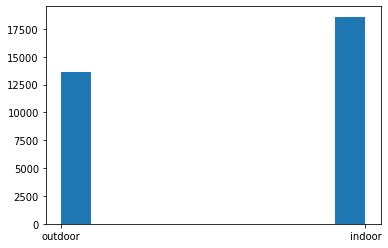

In [ ]:
plt.hist(train_y_texture)
plt.show()

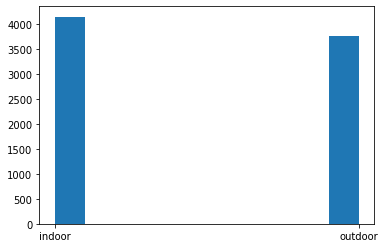

In [ ]:
plt.hist(test_y_texture)
plt.show()

In [ ]:
knnEUC_texture = KNeighborsClassifier(13)
knnEUC_texture.fit(train_X_texture, train_y_texture)
test_predicts_texture =knnEUC_texture.predict(test_X_texture)
train_predicts_texture = knnEUC_texture.predict(train_X_texture)

In [ ]:
accuracy_score(test_y_texture, test_predicts_texture)

0.6613434727503169

In [ ]:
encoder = LabelEncoder().fit(test_y_texture)
true_y = encoder.transform(test_y_texture)
predicted_y = encoder.transform(test_predicts_texture)

In [ ]:
f1_score(true_y,predicted_y)

0.66449020592667

## Объединение цветовых и текстурных предсказании

In [ ]:
boosting_color = pd.DataFrame({'image':train_color_hists['image'], 'predict': encoder.transform(train_predicts_color)})
boosting_color.head()          

,image,predict
0,00_0002,1
1,00_0002,1
2,00_0002,1
3,00_0002,1
4,00_0002,1


In [ ]:
test_boosting_color = pd.DataFrame({'image':test_color_hists['image'], 'predict': encoder.transform(test_predicts_color)})
test_boosting_color.head()        

,image,predict
0,00_0010_aug0,0
1,00_0010_aug1,0
2,00_0010_aug2,0
3,00_0010_aug3,0
4,00_0010_aug4,0


In [ ]:
boosting_texture = pd.DataFrame({'image':texture_features['image'], 'predict': encoder.transform(train_predicts_texture)})
boosting_texture.head()

,image,predict
0,00_0002,1
1,00_0002,1
2,00_0002,1
3,00_0002,0
4,00_0002,1


In [ ]:
test_boosting_texture = pd.DataFrame({'image':test_texture_features['image'], 'predict': encoder.transform(test_predicts_texture)})
test_boosting_texture.head()

,image,predict
0,00_0010_aug0,1
1,00_0010_aug1,0
2,00_0010_aug2,1
3,00_0010_aug3,0
4,00_0010_aug4,0


In [ ]:
texture_grouped = boosting_texture.groupby('image').agg(list)
color_grouped = boosting_color.groupby('image').agg(list)

In [ ]:
texture_grouped.head()

,predict
image,
00_0002,"[1, 1, 1, 0, 1, 1, 0, 1, 1, 1]"
00_0004,"[1, 1, 1, 0, 1, 1, 1, 1, 1, 1]"
00_0007,"[1, 1, 1, 1, 1, 1, 0, 1, 1, 1]"
00_0013,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"
00_0015,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 1]"


In [ ]:
test_texture_grouped = test_boosting_texture.groupby('image').agg(list)
test_color_grouped = test_boosting_color.groupby('image').agg(list)

In [ ]:
test_texture_grouped.head()

,predict
image,
00_0010,"[0, 0, 1, 0, 0, 1, 0, 0, 0, 0]"
00_0010_aug0,"[1, 0, 0, 1, 0, 0, 0, 1, 1, 0]"
00_0010_aug1,"[0, 0, 0, 0, 0, 0, 1, 1, 0, 0]"
00_0010_aug2,"[1, 0, 1, 0, 0, 1, 0, 0, 1, 0]"
00_0010_aug3,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]"


## Получение финального датасета с предсказаниями

In [ ]:
def combiner_color_texture(texture_grouped, color_grouped, train_data):
  color_texture_features = []
  for i in texture_grouped.index:
    img_name = i
    if 'aug' in i:
      img_name = i[:-5]
    texture_row = texture_grouped.loc[i]
    color_row = color_grouped.loc[i]
    color_texture_features.append(np.concatenate((*texture_row, *color_row,[i] ,train_data[train_data['image'] == img_name]['place'].values)))
  train_color_texture_feature = pd.DataFrame(color_texture_features, columns=[*list(range(20)), 'image','label'])
  return train_color_texture_feature

In [ ]:
train_color_texture_feature = combiner_color_texture(texture_grouped, color_grouped, train_data)
train_color_texture_feature.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,image,label
0,1,1,1,0,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,00_0002,outdoor
1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,00_0004,outdoor
2,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,00_0007,outdoor
3,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,00_0013,outdoor
4,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,00_0015,indoor


In [ ]:
test_color_texture_feature = combiner_color_texture(test_texture_grouped, test_color_grouped, test_data)
test_color_texture_feature.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,image,label
0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,00_0010,indoor
1,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,00_0010_aug0,indoor
2,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,00_0010_aug1,indoor
3,1,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,00_0010_aug2,indoor
4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,00_0010_aug3,indoor


выберем логистическую регресию в качестве финальной модели

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [ ]:
final_model = LogisticRegression()

In [ ]:
final_train_X = train_color_texture_feature[train_color_texture_feature.columns[:-2]].values
final_test_X = test_color_texture_feature[test_color_texture_feature.columns[:-2]].values
final_train_y = encoder.transform(train_color_texture_feature[train_color_texture_feature.columns[-1]].values)
final_test_y = encoder.transform(test_color_texture_feature[test_color_texture_feature.columns[-1]].values)

In [ ]:
final_model.fit(final_train_X, final_train_y)

LogisticRegression()

In [ ]:
final_predicts = final_model.predict(final_test_X)

## Итоговый результат

In [ ]:
accuracy_score(final_test_y,final_predicts )

0.9416983523447402

In [ ]:
f1_score(final_test_y,final_predicts)

0.9401041666666667

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


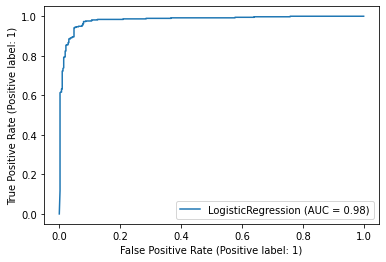

In [ ]:
metrics.plot_roc_curve(final_model, final_test_X, final_test_y) 

## Вывод

итоговый результат получился достаточно неплохим, однако стоит помнить, что в абсолютное большенство эелементов тестовой выборки  класса 'indoor' были воссозданы искуссвенно, так же не была учтены те изображения, которые не были размечены